# Estimating rates and dates from time-stamped sequences
Data and models from the [BEAST documentation](https://beast.community/rates_and_dates),
though we tweak priors.

In [2]:
from treeflow import Alignment, AlignmentFormat

alignment = Alignment("demo-data/YFV.nex", format=AlignmentFormat.NEXUS)
alignment

Silencing TensorFlow...


Alignment(taxon_count=71, pattern_count=654)

In [3]:
from treeflow import parse_newick

starting_tree = parse_newick("demo-data/YFV.newick")
sequence_tensor = alignment.get_encoded_sequence_tensor(starting_tree.taxon_set)
sequence_tensor.shape

TensorShape([654, 71, 4])

We define a model using [TreeFlow's YAML model definition format](https://github.com/christiaanjs/treeflow/blob/master/docs/model-definition.md). As we can see from the model definition string `model_string`, we are using a strict clock rate model, Gamma site rate variation with four categories, a HKY substitution model, and a coalescent tree prior with a constant population size. We place log-Normal priors on all the parameters (except the substitution model frequencies which have a Dirichlet prior). 

We parse the model definition string into a nested dictionary using Python's `yaml` library, and pass that to TreeFlow's `PhyloModel` class constructor. This class is converted into a TensorFlow Probability's `JointDistribution` using `phylo_model_to_joint_distribution`. This joint distribution class implements methods like `log_prob` and `sample`. The final statement of this code block examines the composition of samples from this joint distribution; it is a nested structure of Tensors which represent the variables of the model. The type of this structure is generated by `tensorflow_probability`'s [`JointDistributionCoroutine`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionCoroutine). Later we'll examine a different joint distribution type which produces a slightly different structure of Tensors (a Python dictionary).

The `tree` variable is an instance of the `TensorflowRootedTree` class, which is a data class that holds a tensor of internal node heights (`node_heights`), leaf node sampling times (`sampling_times`), and the tree topology (`topology`). The tree topology is also a data class with index vectors representing the parent and child indices of nodes, and a preorder traversal of the tree.

Currently the sampling of the coalescent tree and alignment distributions are dummy methods which samples zeros in the expected shape of the alignment, hence the "Dummy sampling" warnings.

In [4]:
import yaml
import tensorflow as tf
from treeflow import (
    PhyloModel,
    convert_tree_to_tensor,
    phylo_model_to_joint_distribution
)

model_string = """
clock:
  strict:
    clock_rate:
      lognormal:
        loc: -2.0
        scale: 2.0
site:
  discrete_gamma:
    category_count: 4
    site_gamma_shape:
      lognormal:
        loc: 0.0
        scale: 1.0
substitution:
  hky:
    kappa:
      lognormal:
        loc: 1.0
        scale: 1.25
    frequencies:
      dirichlet:
        concentration:
        - 2.0
        - 2.0
        - 2.0
        - 2.0
tree:
  coalescent:
    pop_size:
      lognormal:
        loc: 1.0
        scale: 1.5
"""

model_dict = yaml.safe_load(model_string)
model = PhyloModel(model_dict)
starting_tensor_tree = convert_tree_to_tensor(starting_tree)
model_dist = phylo_model_to_joint_distribution(model, starting_tensor_tree, alignment)
model_dist_sample = model_dist.sample()
tf.nest.map_structure(lambda x: x.shape, model_dist_sample)

/home/christiaan/uni/treeflow/treeflow/distributions/tree/coalescent/constant_coalescent.py:133: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")
/home/christiaan/uni/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")
/home/christiaan/uni/treeflow/treeflow/distributions/leaf_ctmc.py:62: UserWarning: Dummy sampling of alignment
  warnings.warn("Dummy sampling of alignment")


StructTuple(
  pop_size=TensorShape([]),
  tree=TensorflowRootedTree(node_heights=TensorShape([70]), sampling_times=TensorShape([71]), topology=TensorflowTreeTopology(parent_indices=TensorShape([140]), child_indices=TensorShape([141, 2]), preorder_indices=TensorShape([141]))),
  kappa=TensorShape([]),
  frequencies=TensorShape([4]),
  clock_rate=TensorShape([]),
  site_gamma_shape=TensorShape([]),
  alignment=TensorShape([654, 71, 4])
)

We can perform Bayesian inference on this model (given a fixed tree topology) using [Automatic Differentiation Variational Inference](https://www.jmlr.org/papers/volume18/16-107/16-107.pdf). The `fit_fixed_topology_variational_approximation` automatically constructs an approximation to the posterior distribution that assumes independence between variables. It then minimises the KL divergence between this and the true posterior using stochastic gradient descent.

The `RobustOptimizer` class ensures that an occasional numerical overflow (which is fairly likely when computing phylogenetic likelihoods) does not ruin our optimization run. We plot the (stochastic) trace of the loss function to check convergence.

/home/christiaan/uni/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [15:21<00:00, 32.55it/s]


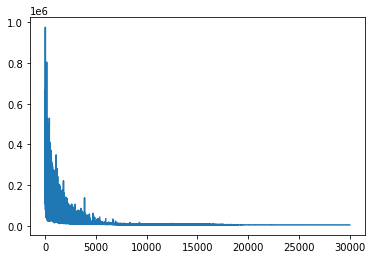

In [5]:
from treeflow.vi import fit_fixed_topology_variational_approximation, RobustOptimizer
from tqdm import tqdm
import matplotlib.pyplot as plt

model_dist_pinned = model_dist.experimental_pin(alignment=sequence_tensor)
optimizer = RobustOptimizer(tf.optimizers.Adam(learning_rate=0.001))
num_steps = 30000
approx, (loss, approx_vars) = fit_fixed_topology_variational_approximation(
    model_dist_pinned,
    topologies=dict(tree=starting_tensor_tree.topology),
    optimizer=optimizer,
    num_steps=num_steps,
    init_loc=dict(tree=starting_tensor_tree),
    progress_bar=tqdm
)
plt.plot(loss)

The `approx_vars` variable records a trace of the parameters of the variational approximating distribution. We can plot these over the course of the optimisation as a further check for convergence. Here we just plot the last index of each of the vector variables, the tree (where it corresponds to the root height) and the frequencies. Each variable has a location and scale parameter for the underlying Normal distribution. These are transformed to fit the appropriate domain for the model variables.

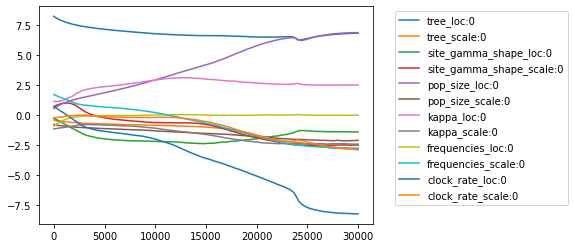

In [13]:
for varname, value in approx_vars.items():
    np_value = value.numpy()
    if len(np_value.shape) > 1:
        np_value = np_value[:, -1]
    plt.plot(np_value, label=varname)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

The easiest way to inspect parameter estimates is through samples from the approximating distribution. We get the variable names from the base model distributions `_flat_resolve_names` method.

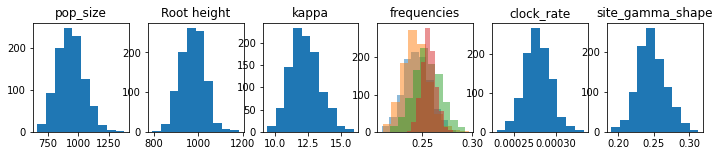

In [49]:
approx_samples = approx.sample(1000)
varnames = model_dist_pinned._flat_resolve_names()
fig, axs = plt.subplots(ncols=len(varnames), figsize=(12, 2))
for ax, varname, samples in zip(axs, varnames, approx_samples):
    np_value = samples.numpy()
    if varname == "tree":
        np_value = samples.node_heights[:, -1]
        ax.set_title("Root height")
    else:
        ax.set_title(varname)
        
    if len(np_value.shape) > 1:
        for i in range(np_value.shape[-1]):
            ax.hist(np_value[:, i], alpha=0.5)
    else:
        ax.hist(np_value)    

### Try model with sequences partitioned into codon

We can try an alternative substitution model by partitioning the alignment into codon positions and estimating separate substitution model parameters for each of them. We can use statistical model selection to compare the support the data has for the model with more parameters. 

In [6]:
codon_partitioned_sequence_tensor = alignment.get_codon_partitioned_sequence_tensor(starting_tree.taxon_set)
codon_partitioned_sequence_tensor.shape

TensorShape([3, 218, 71, 4])

We declare a new model using TensorFlow Probability's [`JointDistributionNamed`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionNamed). This implements a joint distribution over a structure of Tensors, constructed using a dictionary of TensorFlow Probability `Distribution`s or `Distribution`-building functions.
* `kappa`/`frequencies`/`site_gamma_shape`/`pop_size`/`clock_rate`: for brevity, we re-use the priors from the previous model, modifying the `kappa` and `frequencies` for the parameters with the `Sample` meta-distribution. This represents independent identically-distributed samples based on a single base distribution for each of the codon positions.
* `tree`: We use the `ConstantCoalescent` tree distribution implemented by `treeflow` for the distribution on the phylogenetic tree.
* `alignment`: the `build_codon_alignment_distribution` function, which builds the distribution on the observed sequences, makes the structure of this part of the model clear:
  * It first constructs an unrooted tree of genetic distances (in units of expected substitutions per site), which is the product of the branch lengths on the time tree and the constant mutation rate
  * This is used to compute transition probabilities between each of the nodes of the tree using the substitution model parameters. A mixture over a discretized Gamma distribution is used to model site-rate variation
  * The `LeafCTMC` class implements the phylogenetic likelihood which marginalizes over the characters at internal nodes using
  * The `Independent` meta-distribution indicates the distribution is independent over the codon position batch dimension and the log-likelihoods should summed over this dimension
  * The `Sample` meta-distribution represents the identical indendependent samples of the single-codon distribution over the codons

In [7]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from treeflow.distributions import DiscretizedDistribution, SampleWeighted, DiscreteParameterMixture, LeafCTMC
from treeflow.evolution.substitution import HKY, get_transition_probabilities_tree
from treeflow.distributions.tree import ConstantCoalescent

codon_size = codon_partitioned_sequence_tensor.shape[0]
dist_dict = { dist.name: dist for dist in model_dist._get_single_sample_distributions() }

codon_size, codon_count, taxon_count, site_category_count = codon_partitioned_sequence_tensor.shape
subst_model = HKY()

def build_codon_alignment_distribution(kappa, frequencies, tree, clock_rate, site_gamma_shape):
    distance_tree = tree.get_unrooted_tree() * clock_rate
    site_rate_distribution = DiscretizedDistribution(
        category_count=site_category_count,
        distribution=tfd.Gamma(concentration=site_gamma_shape, rate=site_gamma_shape),
    )
    transition_probs_tree = get_transition_probabilities_tree(
        distance_tree,
        subst_model,
        rate_categories=site_rate_distribution.normalised_support,
        frequencies=frequencies,
        kappa=kappa
    )
    batch_ctmc = LeafCTMC(
        transition_probs_tree,
        tf.expand_dims(frequencies, -2) # Add a dimension to frequencies to broadcast with site rate mixture
    )
    site_rate_mixture = DiscreteParameterMixture(
        site_rate_distribution,
        batch_ctmc,
    )
    single_site_dist = tfd.Independent(site_rate_mixture, reinterpreted_batch_ndims=1)
    return tfd.Sample(
        single_site_dist,
        sample_shape=codon_count,
    )

codon_model_dist = tfd.JointDistributionNamed({
    "pop_size": dist_dict["pop_size"],
    "kappa": tfd.Sample(dist_dict["kappa"], sample_shape=codon_size),
    "frequencies": tfd.Sample(dist_dict["frequencies"], sample_shape=codon_size),
    "site_gamma_shape": dist_dict["site_gamma_shape"],
    "clock_rate": dist_dict["clock_rate"],
    "tree": lambda pop_size: ConstantCoalescent(starting_tensor_tree.taxon_count, pop_size, starting_tensor_tree.sampling_times, tree_name="tree"),
    "alignment": build_codon_alignment_distribution
})
codon_model_dist.event_shape

/home/christiaan/uni/treeflow/treeflow/distributions/tree/coalescent/constant_coalescent.py:133: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")
/home/christiaan/uni/treeflow/treeflow/distributions/leaf_ctmc.py:62: UserWarning: Dummy sampling of alignment
  warnings.warn("Dummy sampling of alignment")


{'pop_size': TensorShape([]),
 'tree': TensorflowRootedTree(node_heights=TensorShape([70]), sampling_times=TensorShape([71]), topology=TensorflowTreeTopology(parent_indices=TensorShape([140]), child_indices=TensorShape([141, 2]), preorder_indices=TensorShape([141]))),
 'site_gamma_shape': TensorShape([]),
 'kappa': TensorShape([3]),
 'frequencies': TensorShape([3, 4]),
 'clock_rate': TensorShape([]),
 'alignment': TensorShape([218, 3, 71, 4])}

To match the shape of the alignment distribution, we use `tf.transpose` to swap the first two dimensions (codon index and codon position) of the codon-partitioned encoded alignment Tensor - this is necessary because the `Sample` distribution over codons can only add a outer/left-most dimension. We then pin (condition on) the observed alignment and test the conditional log-likelihood.

In [8]:
site_first_codon_sequence_tensor = tf.transpose(codon_partitioned_sequence_tensor, [1, 0, 2, 3])
codon_model_dist_pinned = codon_model_dist.experimental_pin(alignment=site_first_codon_sequence_tensor)
codon_prior_sample = codon_model_dist.sample()
codon_prior_sample.pop("alignment")
codon_prior_sample["tree"] = starting_tensor_tree
codon_model_dist_pinned.log_prob(codon_prior_sample)

<tf.Tensor: shape=(), dtype=float64, numpy=-66077.80179853331>

Using the same inferential machinery as before, we fit an approximating distribution to the posterior.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [15:16<00:00, 32.73it/s]


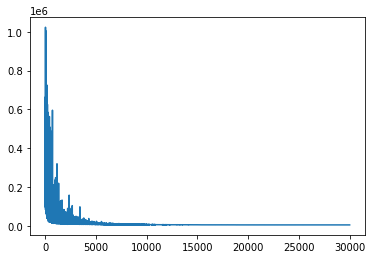

In [9]:
codon_optimizer = RobustOptimizer(tf.optimizers.Adam(learning_rate=0.001))
codon_approx, (codon_loss, codon_approx_vars) = fit_fixed_topology_variational_approximation(
    codon_model_dist_pinned,
    topologies=dict(tree=starting_tensor_tree.topology),
    optimizer=codon_optimizer,
    num_steps=num_steps,
    init_loc=dict(tree=starting_tensor_tree),
    progress_bar=tqdm,
    approx_kwargs=dict(var_name_prefix="codon_"),
)
plt.plot(codon_loss)

We can compare parameter estimates beween the two models, and see that the estimates of the height of the root of the tree and the clock rate differ slightly between the base and codon-partitioned models, at least under the results of our inference procedure.

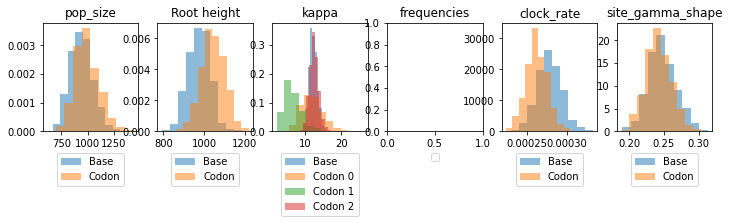

In [69]:
codon_approx_samples = codon_approx.sample(1000)
fig, axs = plt.subplots(ncols=len(varnames), figsize=(12, 2))
for ax, varname, samples in zip(axs, varnames, approx_samples):
    np_value = samples.numpy()
    codon_np_value = codon_approx_samples[varname].numpy()
    if varname == "tree":
        np_value = np_value.node_heights[:, -1]
        codon_np_value = codon_np_value.node_heights[:, -1]
        ax.set_title("Root height")
    else:
        ax.set_title(varname)

    if varname == "kappa":
        ax.hist(np_value, label="Base", alpha=0.5, density=True)
        for i in range(codon_size):
            ax.hist(codon_np_value[:, i], label=f"Codon {i}", alpha=0.5, density=True)    
    elif varname != "frequencies":
        ax.hist(np_value, label="Base", alpha=0.5, density=True)
        ax.hist(codon_np_value, label="Codon", alpha=0.5, density=True)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))

We can use the (log) marginal likelihood to compare the fit of the two models to the observed data. While the negative of the objective function used in inference does provide an estimate (a lower bound) on the marginal likelihood, we can improve the estimate using importance sampling. This is implemented in the `estimate_log_ml_importance_sampling` method. We can see that the marginal likelihood for the codon-partitioned model is slightly higher, which indicates that it is a better explanation for the observed data despite having more parameters.

The `vectorize_log_prob` argument can be set to `False` to save memory if required. 

*Note: this method currently results in a large number of "ignored" exceptions deep inside TensorFlow Probability code but it doesn't appear these affect the results*

In [10]:
import yaml
from treeflow.vi import estimate_log_ml_importance_sampling

ml_n_samples = 100
base_ml_result = estimate_log_ml_importance_sampling(model_dist_pinned, approx, vectorize_log_prob=False, n_samples=ml_n_samples)
codon_ml_result = estimate_log_ml_importance_sampling(codon_model_dist_pinned, codon_approx, vectorize_log_prob=False, n_samples=ml_n_samples)

marginal_likelihood_dict = dict(
    base=base_ml_result.numpy(),
    codon=codon_ml_result.numpy()
)
marginal_likelihood_dict

Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef(StructTuple(
  pop_size=HashableWeakRef(<weakref at 0x7f7887783c20; dead>),
  tree=HashableWeakRef(<weakref at 0x7f7887783770; dead>),
  kappa=HashableWeakRef(<weakref at 0x7f7887783d10; to 'Tensor' at 0x7f7887316430>),
  frequencies=HashableWeakRef(<weakref at 0x7f7887783db0; to 'Tensor' at 0x7f78873167f0>),
  clock_rate=HashableWeakRef(<weakref at 0x7f7887783ea0; to 'Tensor' at 0x7f78873b12b0>),
  site_gamma_shape=HashableWeakRef(<weakref at 0x7f7887783ef0; to 'Tensor' at 0x7f78872d1d90>)
))>
Traceback (most recent call last):
  File "/home/christiaan/.pyenv/versions/3.8.13/envs/treeflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/cache_util.py", line 151, in _cleanup
    self._callback(self)
  File "/home/christiaan/.pyenv/versions/3.8.13/envs/treeflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/cache_util.py", line 221, in maybe_del
    del self[key]
KeyError: W

{'base': -6013.196238400406, 'codon': -6010.9457197782085}